In [ ]:
!scancel -u aschade

In [ ]:
from logging import log
from os.path import exists
from os import makedirs
import shutil
from glob import glob
from tqdm import tqdm
from retrying import retry
from time import time, sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
from matplotlib.ticker import FuncFormatter
pd.options.display.max_rows = 150
pd.options.display.max_columns = 50
import seaborn as sns
sns.set_style("whitegrid")

import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
# dask.config.set({
#     'distributed.workers.memory.spill':          None, 
#     'distributed.scheduler.allowed-failures':    10,
# })

########################################################################################################################
########################################################################################################################
########################################################################################################################

    
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.1f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

human_readable = FuncFormatter(human_format)
    

########################################################################################################################
########################################################################################################################
########################################################################################################################

cluster = SLURMCluster(
    cores=60, 
    memory='200GB',
    
    local_directory='~/scratch',
    job_extra=[
#         '--reservation=lab_rdurante_302',
        '--partition=haswell',    
        '--nodes=1',
        '--time=03:00:00',
        
        '--job-name=dask',
        '--output=dask.out', 
        '--error=dask.error', 
        '--mail-user=aaron.schade@upf.edu',
        '--mail-type=NONE', 
    ],    
    n_workers=1,                 # this is internal to one job? one node? 
    
    interface='ib0',               # workers, no diag: em1, em2, ib0,   # no workers: lo, em1.851, idrac, em3 & em4 (no ipv4)
    scheduler_options={
#         'interface': 'em1',      # it wont allow you specify both an interface AND a host address
        'host': '10.30.50.163',    # launch on this address, open dashboard on the other?
    },
)
cluster.scale(jobs=1)


scheduler = Client(cluster)
print(scheduler)
dashboardLink = scheduler.dashboard_link.replace('10.30.50.163', '10.60.110.163')
# dashboardLink = scheduler.dashboard_link
print(dashboardLink)
print(dashboardLink.replace('status', 'workers'))
print(dashboardLink.replace('status', 'graph'))

In [ ]:
sleep(1)

In [ ]:
!squeue -u aschade

In [ ]:
orders = dd.read_parquet('~/scratch/glovo/parquet/orders')
stores = dd.read_parquet('~/scratch/glovo/parquet/stores')
couriers = dd.read_parquet('~/scratch/glovo/parquet/couriers')
orderStores = dd.read_parquet('~/scratch/glovo/parquet/ordersWithStores/').reset_index()
orderStores.head()

In [ ]:
# groupby('week')
orderStores['week'] = orderStores.date.apply(lambda cell: cell.week, meta=('date', 'int64'))
orderStores['year'] = orderStores.date.apply(lambda cell: cell.year, meta=('date', 'int64'))


In [ ]:
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################

In [ ]:
################################################ weekly restaurant data #######################################################

In [ ]:
def invertDict(countryToLabel):
    labelToCountry = {}
    
    for country, labelList in countryToLabel.items():
        for label in labelList:
            labelToCountry.setdefault(label, country)
            
    return labelToCountry

countryToLabel = {
    'other': [
        'Groceries', 
        'Snacks', 
        'Chicken', 
        'Healthy', 
        'Sweets', 
        'International', 
        'Gifts', 
        'Sandwich', 
        'Grill (Barbeque)', 
        'Icecream', 
        'Other', 
        'Pharmacy', 
        'Grill', 
        'Ice Cream', 
        'Drinks', 
        'Seafood', 
        'Vegan / Vegetarian', 
        'Flowers', 
        'Regalo (Gifts)', 
        'Cacher', 
        'Oriental,Cacher', 
        'Cacher,Groceries', 
        'Sweets,Snacks', 
        'Fast Food,Ice Cream', 
        'Sweets,Ice Cream',
        'Pollo', 
        'International,Healthy', 
        'Snacks,Sweets', 
        'Sandwich,Snacks', 
        'Asian,International', 
        'Fast Food,Apero', 
        'Japanese,Mediterranean', 
        'Groceries,Apero', 
        'Cacher,International', 
        'Apero,Sandwich', 
        ], 
    
    'Asia':     ['Asian'],
    'US':       ['Burger', 'American', 'Fast Food', 'American,Sandwich', 'Cacher,Burger', 'American,Burger', 'Burger,American'], 
    'Italy':    ['Pizza & Italian','Pizza','Italian', 'Panini', 'italiana', 'Piadina', 'Pizza & Italian,Cacher', 'Cacher,Pizza & Italian', 'Pizza & Italian,French', 'Pizza & Italian,Healthy', ], 
    'Japan':    ['Japanese','Sushi', 'Asian,Japanese', 'Japanese,Asian', 'Japanese,Cacher', 'Cacher,Japanese'], 
    'Middle East':   ['Oriental', 'Shawarma', 'International,Oriental', 'Healthy,Japanese', ], 
    'Turkey':   ['Turkish', ], 
    'Latin America': ['Latin', ], 
    'Brazil':   ['Brazil', 'Brazilian', ], 
    'Mexico':   ['Mexican', 'Tacos', 'Mexican,Fast Food', 'Mexican,Burger', ], 
    'Hawaii':   ['Poke', ], 
    'Lebanon':  ['Lebanese', 'Oriental,Lebanese', 'Lebanese,International', 'Lebanese,Oriental', ], 
    'Spain':    ['Spanish', ], 
    'Georgia':  ['Georgian', ], 
    'Argentina': ['Argentinian', ], 
    'Greece':   ['Greek', ], 
    'Ukraine':  ['Ukranian', ], 
    'Thailand': ['Thai', 'Thai,Asian', 'Asian,Thai', ], 
    'Romania':  ['Romanian', ], 
    'India':    ['Indian', ], 
    'France':   ['French', 'French,Healthy', 'French,Burger', 'Burger,French', 'Healthy,French', 'Burger,Cacher,French', 'Seafood,French', 'Fast Food,French', ], 
    'Africa':   ['African', ], 
    'Portugal': ['Portuguese', ], 
    'Egypt':    ['Egyptian', ], 
    'Vietnam':  ['Vietnamese', ], 
    'Ecuador':  ['Ecuadorian', ], 
    'Peru':     ['Peruvian', ], 
    'Europe':   ['European', 'Mediterranean,International', 'Mediterranean'], 
    'Morocco':  ['Morrocan', 'Moroccan'], 
    'China':    ['Chinese', 'Asian,Chinese', 'International,Chinese', 'Thai,Asian,Chinese', 'Chinese,Asian', ]
    }

labelToCountry = invertDict(countryToLabel)
labelToCountry

In [ ]:
# culinary origin
def getCulinaryOrigin(cell):
    try:
        return labelToCountry[cell.strip()]
    except:
        return ''
    
orderStores['culinary_origin'] = orderStores.store_tag.apply(getCulinaryOrigin, meta=('store_tag', 'object'))




In [ ]:
# aggregation by date, restaurant, city
aggregated = (
    orderStores
    .groupby(['year', 'week', 'store_name', 'store_address_id', 'city'])
    .agg({
        'culinary_origin': 'first',
        'store_tag':       'first', 
        'id':              'count', 
        })
    .rename(columns={
        'id':      'orders_this_restaurant_this_week', 
        })
    .reset_index()          # partial removing of indices not working? and later set_index(['year', 'week']) not implemented
)
aggregated

In [ ]:
# orders in that city, in that week, all of glovo
totalRegionalOrders = (
    orderStores
    .groupby(['year', 'week', 'city'])
    .size()
)
totalRegionalOrders.name = 'orders_this_city_this_week'
totalRegionalOrders

In [ ]:
# merge aggregation with regional orders 
aggregation = dd.multi.merge(aggregated, totalRegionalOrders, how='left', on=['year', 'week', 'city'])
aggregation.to_csv('outputs/restaurant_aggregation.csv', single_file=True)


In [ ]:
# look at results
df = pd.read_csv('outputs/restaurant_aggregation.csv', index_col='Unnamed: 0')
df

In [ ]:
# add restaurant share and date
df['restaurant_share'] = df.orders_this_restaurant_this_week / df.orders_this_city_this_week
df['date'] = pd.to_datetime(df.year.astype(str), format='%Y') + pd.to_timedelta(df.week.mul(7).astype(str) + ' days')
df.to_csv('outputs/restaurant_aggregation.csv')
df

In [ ]:
df.culinary_origin.value_counts(dropna=False, normalize=False)

In [ ]:
df[
    (df.culinary_origin == '') &
    (df.store_tag != '')
]

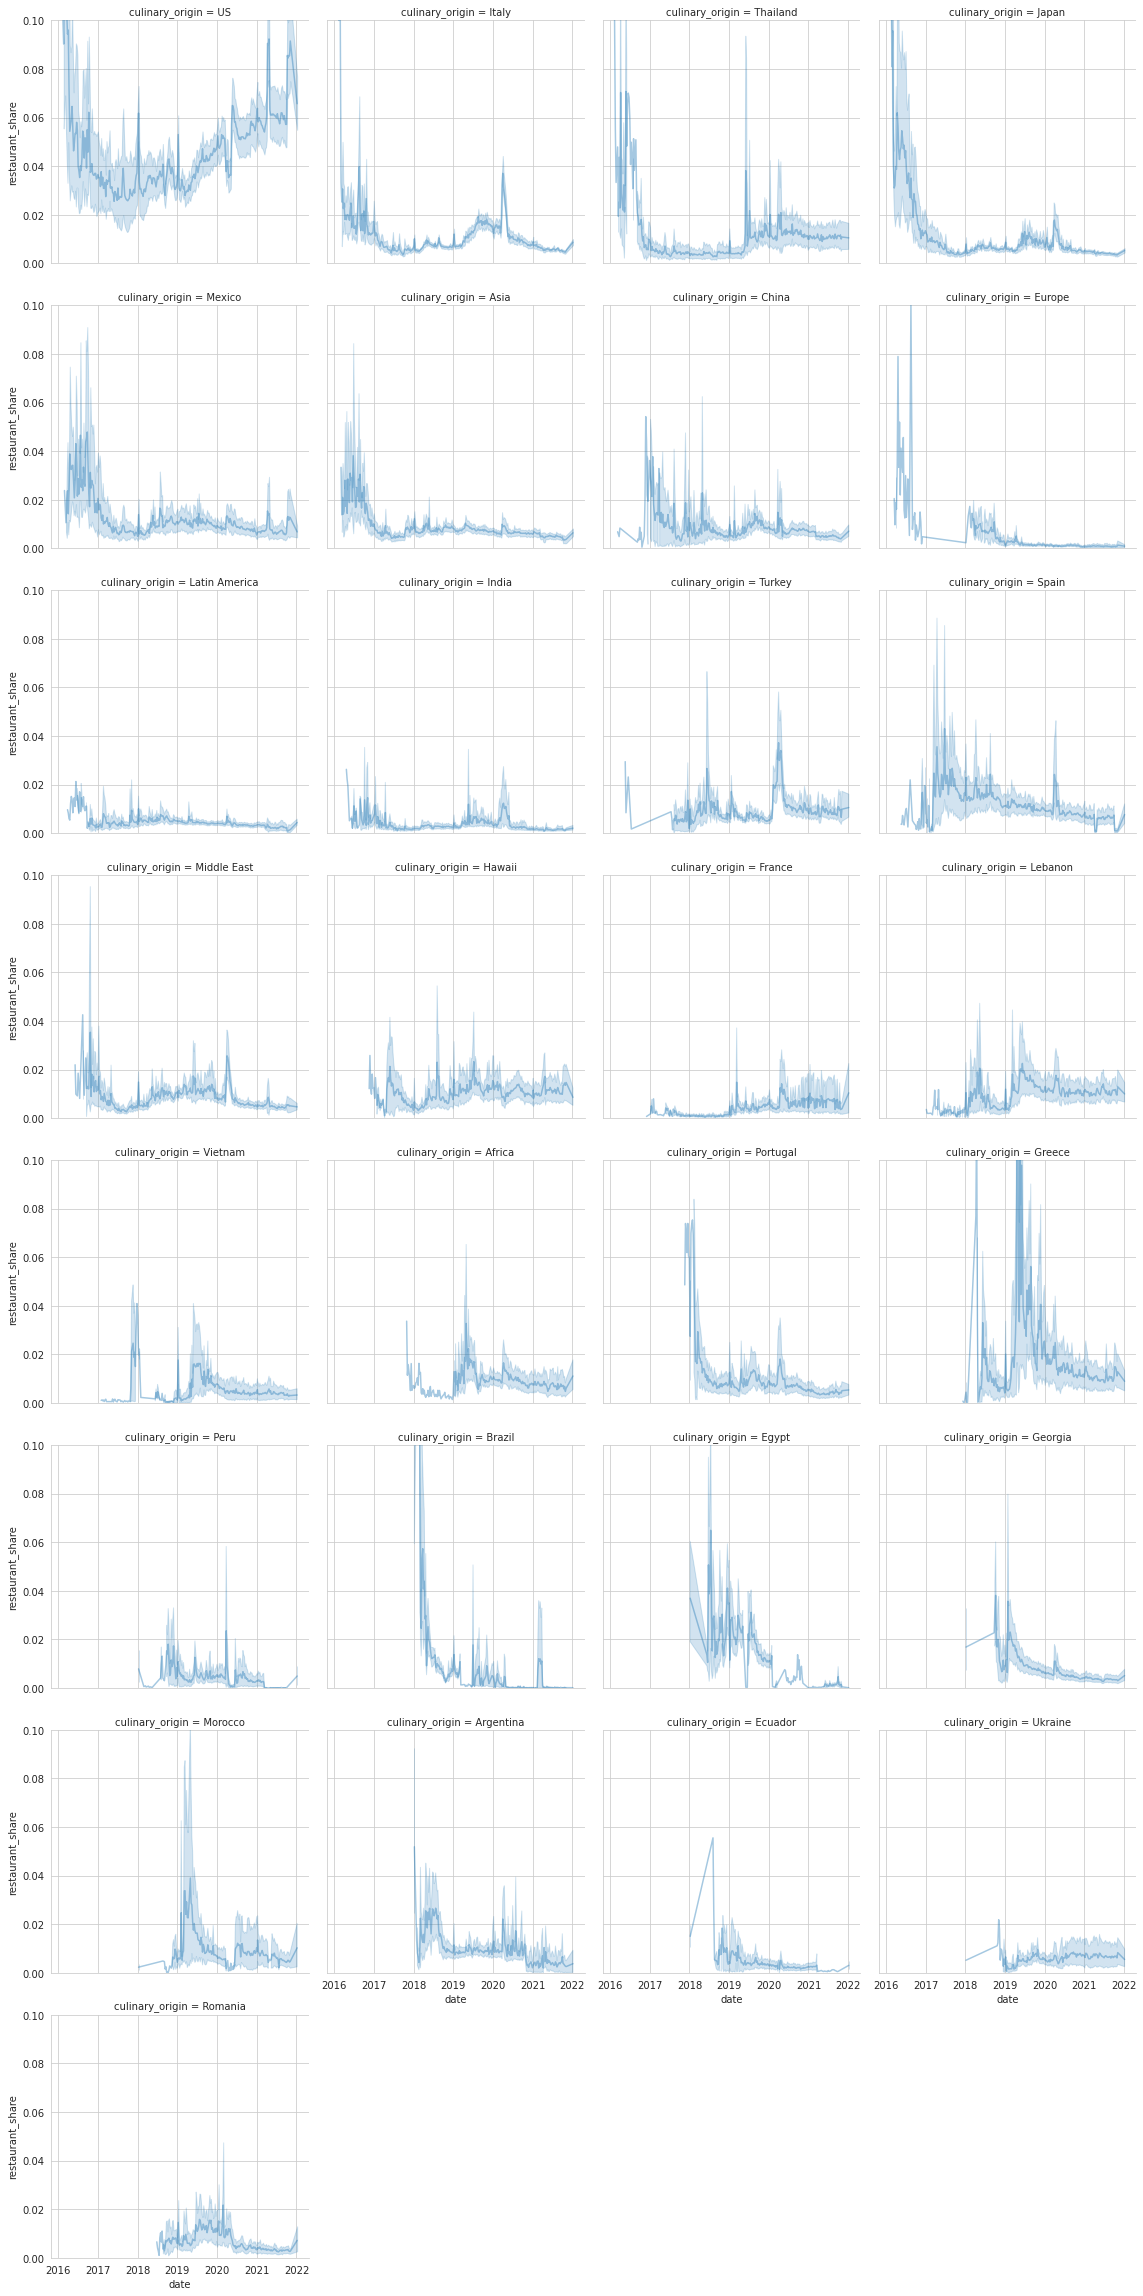

In [23]:
g = sns.FacetGrid(
    df[~df.culinary_origin.isin(['other', 'na'])], 
    col='culinary_origin',
    col_wrap=4,
    ylim=(0, 0.10), 
    height=4, 
    aspect=1,
)
g.map(sns.lineplot, 'date', 'restaurant_share', alpha=0.4)
g.fig.savefig('outputs/graphs/restaurant_share_timeseries.png')

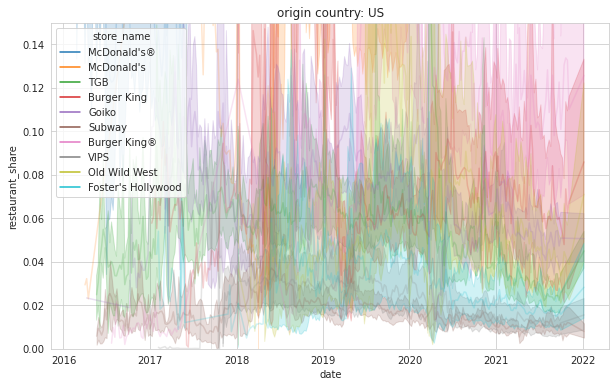

In [70]:
for origin in [item for item in df.culinary_origin.unique() if item != 'other']:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    temp = df[df.culinary_origin == origin]
    
    sns.lineplot(
        data=temp, 
        x='date', 
        y='restaurant_share', 
        hue='store_name',
        hue_order=temp.store_name.value_counts().iloc[:10].index, 
        
        alpha=0.2,
        axes=ax,
        )
    ax.set_ylim(0, 0.15)
    ax.set_title(f'origin country: {origin}')
    
    plt.savefig(f'outputs/graphs/timeseries_{origin}.png')
    break

In [ ]:
################################################ new stores ###################################################################

In [7]:
stores['store_creation_time'] = dd.to_datetime(
    stores['store_creation_time'], 
    errors='coerce', 
    exact=False,                    # allows match to be found anywhere in string
    infer_datetime_format=True,     # if no 'format' is given, infer it -> potential speed-up, we only look at one year at a time, when the format should be consistent
    )
stores = stores.set_index('store_creation_time')
stores.head()

,store_address_id,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
store_creation_time,,,,,,,,,,
2016-01-21 13:49:32,NaN,Pizza Market,BCN,RESTAURANT,,True,Local Hero,good pizza,,0.0
2016-01-21 13:54:23,127786.0,Carrefour,BCN,SuperGlovo,Groceries,True,Other,Mismos precios que en tienda,2016-02-13 10:52:54.000000,7532.0
2016-01-21 13:54:23,109.0,Carrefour,BCN,SuperGlovo,Groceries,True,Other,Mismos precios que en tienda,2016-02-13 10:52:54.000000,83.0
2016-01-21 13:54:23,127794.0,Carrefour,BCN,SuperGlovo,Groceries,True,Other,Mismos precios que en tienda,2016-02-13 10:52:54.000000,3762.0
2016-01-21 13:54:23,134338.0,Carrefour,BCN,SuperGlovo,Groceries,True,Other,Mismos precios que en tienda,2016-02-13 10:52:54.000000,0.0


In [9]:
# delta all stores
newStoresAll = (
    stores
    .store_name
    .resample('W')
    .count()
    .compute()
    .rename('new_stores_all')
    )

# delta chinese stores
newStoresChinese = (
    stores[stores.store_tag.isin(chineseLabels)]
    .store_name
    .resample('W')
    .count()
    .compute()
    .rename('new_stores_chinese')
    )

newStores = pd.merge(newStoresAll, newStoresChinese, left_index=True, right_index=True)
newStores['ratio'] = newStores.new_stores_chinese / newStores.new_stores_all

newStores

,new_stores_all,new_stores_chinese,ratio
store_creation_time,,,
2016-01-24,72,0,0.0
2016-01-31,0,0,NaN
2016-02-07,7,0,0.0
2016-02-14,110,0,0.0
2016-02-21,275,0,0.0
...,...,...,...
2021-10-24,2189,0,0.0
2021-10-31,2547,0,0.0
2021-11-07,2277,0,0.0


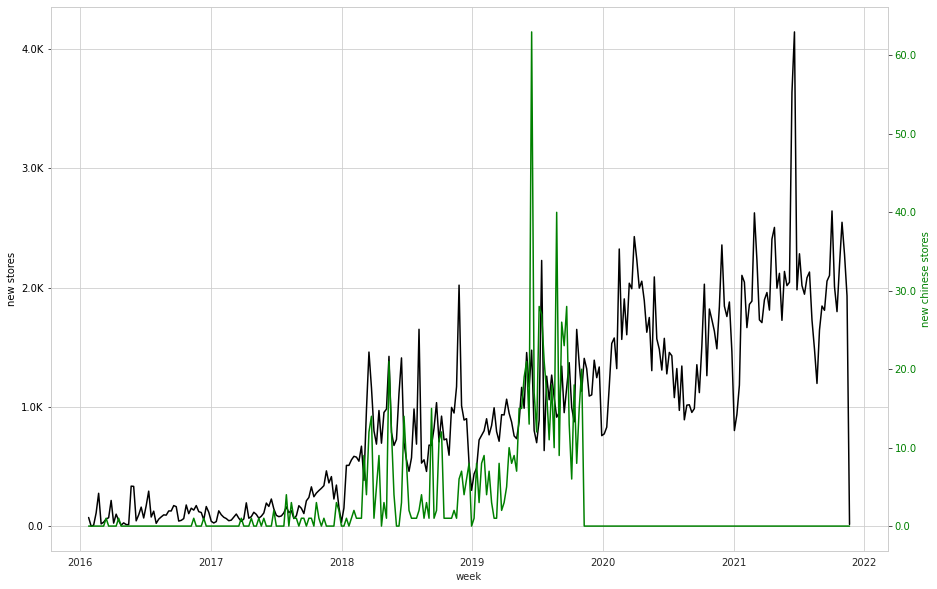

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 10)) 
ax1.set_xlabel('week') 

ax1.plot(newStores.new_stores_all, color = 'black') 
ax1.tick_params(axis ='y', labelcolor = 'black') 
ax1.set_ylabel('new stores', color = 'black') 
ax1.yaxis.set_major_formatter(human_readable)


ax2 = ax1.twinx() 
ax2.plot(newStores.new_stores_chinese, color = 'green') 
ax2.tick_params(axis ='y', labelcolor = 'green') 
ax2.set_ylabel('new chinese stores', color = 'green') 
ax2.yaxis.set_major_formatter(human_readable)

plt.grid(False)
plt.show()

In [ ]:
###################################################### weekly orders ##########################################################

In [ ]:
# weekly timeseries of all orders
allOrderCount = (
    orderStores
    .id
    .resample('W')
    .count()
    .compute()
    .rename('all_orders')
    )

# weekly timeseries of chinese orders
chineseOrderCount = (
    orderStores[orderStores.store_tag.isin(chineseLabels)]
    .id
    .resample('W')
    .count()
    .compute()
    .rename('chinese_orders')
    )

orderCounts = pd.merge(allOrderCount, chineseOrderCount, left_index=True, right_index=True)
orderCounts['ratio'] = orderCounts.chinese_orders / orderCounts.all_orders

orderCounts

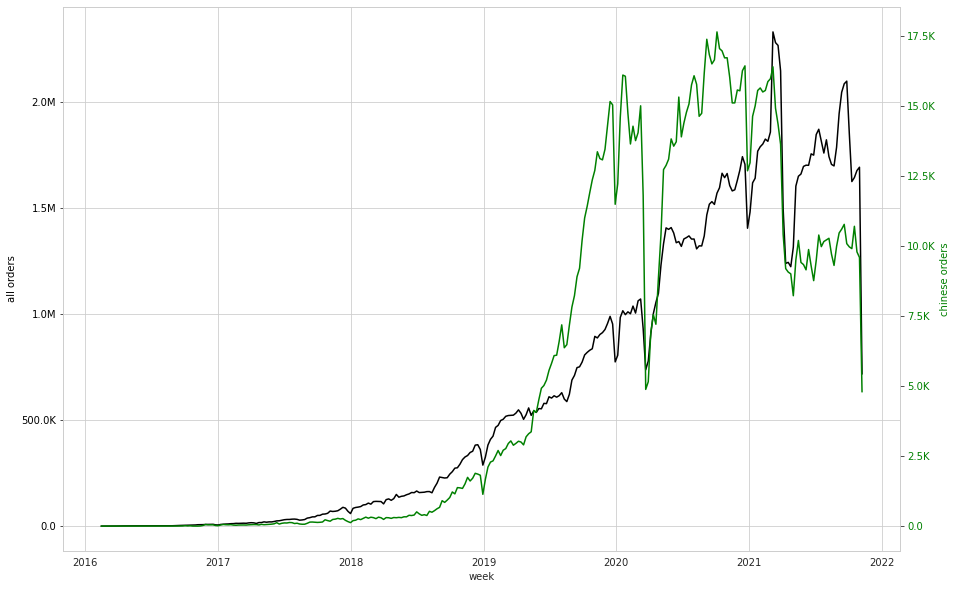

In [8]:
fig, ax1 = plt.subplots(figsize=(15, 10)) 
ax1.set_xlabel('week') 

plot_1 = ax1.plot(orderCounts.index, orderCounts.all_orders, color = 'black') 
ax1.tick_params(axis ='y', labelcolor = 'black') 
ax1.set_ylabel('all orders', color = 'black') 
ax1.yaxis.set_major_formatter(human_readable)


ax2 = ax1.twinx() 
plot_2 = ax2.plot(orderCounts.index, orderCounts.chinese_orders, color = 'green') 
ax2.tick_params(axis ='y', labelcolor = 'green') 
ax2.set_ylabel('chinese orders', color = 'green') 
ax2.yaxis.set_major_formatter(human_readable)

plt.grid(False)
plt.show()

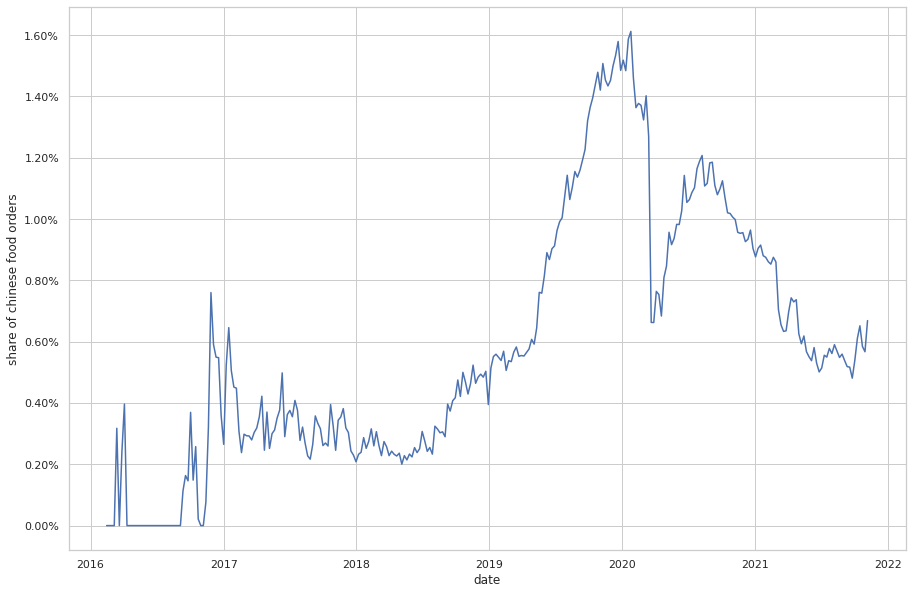

In [16]:
from  matplotlib.ticker import PercentFormatter
sns.set(rc={'figure.figsize':(15, 10)}, style='whitegrid')

ax = sns.lineplot(data=orderCounts.ratio)
ax.set_ylabel('share of chinese food orders')
ax.yaxis.set_major_formatter(PercentFormatter(1))